In [1]:
# Uncommenting the lines below installs all needed packages to the notebook environment instead of local machine
# %pip install pyfinance
# %pip install py_vollib
# %pip install pandas
# %pip install matplotlib

import pandas as pd
from pyfinance.options import BSM
from datetime import datetime, timedelta
import py_vollib
from py_vollib.black_scholes.implied_volatility import implied_volatility
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../data/apple.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df['date'] = pd.to_datetime(df['Date'])
df['T'] = (pd.to_datetime('2024-01-19') - df['date']).dt.days / 252 # T = time to expiration in years, 252 trading days
df = df.drop(["date"], axis=1)
df.head()

#interest rate data
df2 = pd.read_csv('../code/csv-data/daily-treasury-rates.csv')
df2 = df2[['Date', '13 WEEKS COUPON EQUIVALENT']]
df2['Date'] = pd.to_datetime(df2['Date'], format='%m/%d/%Y')
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d')
df2 = df2[df2['Date'] >= '2023-08-21']
df2['13 WEEKS COUPON EQUIVALENT'] = df2['13 WEEKS COUPON EQUIVALENT'] / 100
df_result = pd.merge(df, df2, on='Date', how='left')
df_result.rename({"13 WEEKS COUPON EQUIVALENT": "Interest rate"}, axis="columns", inplace=True)
df_result['Interest rate'].fillna(df_result['Interest rate'].median(), inplace=True)
df_result.head()

,Date,Underlying,C170,C175,C180,C185,C190,P170,P175,P180,P185,P190,T,Interest rate
0,2023-08-21,175.84,16.40,13.27,10.30,7.85,5.91,6.81,8.65,10.85,13.35,16.50,0.599206,0.0546
1,2023-08-22,177.23,17.50,14.10,11.10,8.51,6.34,6.26,8.10,10.10,12.75,15.50,0.595238,0.0546
2,2023-08-23,181.12,20.20,16.65,13.45,10.55,8.08,5.25,6.71,8.50,10.70,13.33,0.591270,0.0546
3,2023-08-24,176.38,16.97,13.75,10.80,8.35,6.25,6.85,8.62,10.75,13.35,16.60,0.587302,0.0547
4,2023-08-25,178.61,18.50,15.15,11.85,9.19,6.90,5.90,7.50,9.50,11.90,14.81,0.583333,0.0550


### This is a helper function extracted to its own method

In [2]:
def get_greeks_for_option(option, call_vola, put_vola, call_strike, put_strike):
    call_bsm = BSM(kind='call', S0=option['Underlying'], K=call_strike, T=option['T'], r=option['Interest rate'], sigma=call_vola)
    put_bsm = BSM(kind='put', S0=option['Underlying'], K=put_strike, T=option['T'], r=option['Interest rate'], sigma=put_vola)
    return call_bsm.delta(), call_bsm.gamma(), call_bsm.vega(), put_bsm.delta(), put_bsm.gamma(), put_bsm.vega()
    

# Delta-Vega-Gamma hedging a single option

In [3]:
# TODO: refactor when time
def delta_vega_gamma_hedge(option_data, freq, call_column, put_column, costs = 0):
    # Initial values at time t = 0
    initial = option_data.iloc[0]
    option_amount = 1000
    interest_rate = initial['Interest rate']
    stock_price = initial['Underlying']
    call_option_price = initial[call_column]
    put_option_price = initial[put_column]
    call_strike = int(call_column[1:])
    put_strike = int(put_column[1:])
    time_to_maturity = initial['T']
    total_mean_squared_error = []
    
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=call_strike, t=time_to_maturity, r=interest_rate, flag='c')
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=put_strike, t=time_to_maturity, r=interest_rate, flag='p')

    # Initial stuff at t = 0
    # REMEMBER: Delta of the underlying stock is 1, Gamma is 0, Vega is 0
    # To make the portfolio Gamma and Vega neutral, we have to take both call and put options
    # Gamma expresses how much hedging will cost in a small time interval
    # If Gamma of the portfolio is positive, we make money by delta hedging and vice versa
    # With both Delta and Gamma hedging, we obtain a portfolio, which is even less sensitive to small price changes of the underlying
    # Need to rebalance the hedge for a Delta and Gamma neutral portfolio occurs less often, which saves trading costs
    # Delta neutrality can be achieved by fixing the option positions
    call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(initial, call_volatility, put_volatility, call_strike, put_strike)

    # Construct portfolio OP, long position ?
    OP = option_amount * call_option_price + option_amount * put_option_price

    # Construct portfolio RE, short position ?
    RE = - call_delta * stock_price * option_amount + put_delta * stock_price * option_amount
    portfolio_values = [OP + RE]
    transaction_costs = 0
    
    print("================ Initial values: =================")
    print("Date:", initial['Date'])
    print(f"Value of single call option (for {option_amount} stocks) according to BSM: ", round(OP, 2))
    print("Value of the short position according to BSM: ", round(RE, 2))
    print("================ GREEKS =================")
    print("Delta of the Call option according to BSM: ", round(call_delta, 2))
    print("Delta of the Put option according to BSM: ", round(put_delta, 2))
    print("Gamma of the Call option according to BSM: ", round(call_gamma, 4))
    print("Gamma of the Put option according to BSM: ", round(put_gamma, 4))
    print("Vega of the Call option according to BSM: ", round(call_vega, 2))
    print("Vega of the Put option according to BSM: ", round(put_vega, 2))
    print('==================================================')
    print('\n')
    
    # Constructing a dataframe for option greeks and implied volatilities, which can then be used later for analysis purposes
    column_names = ['call_delta', 'put_delta', 'call_gamma', 'put_gamma', 'call_vega', 'put_vega', 'call_volatility', 'put_volatility', 'rehedging']
    idx = option_data['Date']

    new_row = pd.DataFrame({'call_delta': call_delta, 'put_delta': put_delta, 'call_gamma': call_gamma, 'put_gamma': put_gamma,
                            'call_vega': call_vega, 'put_vega': put_vega, 'call_volatility': call_volatility, 'put_volatility': put_volatility,
                            'rehedging': False}, index=idx)
    
    greek_and_volatility_data = pd.DataFrame(data = new_row, index = idx, columns=column_names)
    new_rows = []

    hedge = False
    
    # Loop through dates in the dataframe
    # We will also calculate changes in the portfolio's OP and RE, d OP and d RE, and count the mean squared error A_0 = d OP - d RE
    for i in range(1, len(option_data)-1):
        new_OP = option_data[call_column][i] * option_amount + option_data[put_column][i] * option_amount
        new_RE = -call_delta * option_data['Underlying'][i] * option_amount + put_delta * option_data['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE
        a_0 = d_OP + d_RE # In a ideal situation this should be 0 = IMMUNE TO CHANGES
        total_mean_squared_error.append(a_0**2)
        portfolio_values.append(OP + RE + transaction_costs)

        print('=================================================')
        print("Date:", option_data['Date'][i])
        print(f"Value of Call options (for {option_amount} stocks) according to BSM: ", round(new_OP, 2))
        print("Value of the new short position according to BSM: ", round(new_RE, 2))
        print("Difference of the long positions: ", round(d_OP))
        print("Difference of the short positions: ", round(d_RE))
        print('================ GREEKS =========================')
        print("Delta of the Call option according to BSM: ", round(call_delta, 2))
        print("Delta of the Put option according to BSM: ", round(put_delta, 2))
        print("Gamma of the Call option according to BSM: ", round(call_gamma, 4))
        print("Gamma of the Put option according to BSM: ", round(put_gamma, 4))
        print("Vega of the Call option according to BSM: ", round(call_vega, 2))
        print("Vega of the Put option according to BSM: ", round(put_vega, 2))
        print("Total error, difference of the portfolios: ", round(a_0, 2))
        print('=================================================')
        print('\n')

        OP = new_OP
        RE = new_RE
        
        # Rehedge interval
        # Compute new Deltas, Vegas, and Gammas every time we want to rehedge
        # We need to rehedge, because as time goes by, the price of the underlying changes
        # This affects the option Greeks that measure the market
        if i % freq == 0:
            print("Rehedging date: ", option_data['Date'][i])
            
            call_volatility = implied_volatility(price=option_data[call_column][i], S=option_data['Underlying'][i], K=call_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='c')
            put_volatility = implied_volatility(price=option_data[put_column][i], S=option_data['Underlying'][i], K=put_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='p')
            call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(option_data.iloc[i], call_volatility, put_volatility, call_strike, put_strike)
            
            all_greeks_coefficients = np.array([
                [call_delta, call_gamma, call_vega],
                [put_delta, put_gamma, put_vega],
                [1, 0, 0]
                # Delta of the underlying is always 1, Gamma is always 0, Vega is always 0
            ])

            right_hand_side = np.array([
                option_amount * (call_delta + put_delta),
                option_amount * (call_gamma + put_gamma),
                option_amount * (call_vega + put_vega)
            ])

            # Solve the linear equations for the amount of underlying, calls and puts
            delta_vega_gamma_neutral = np.linalg.solve(all_greeks_coefficients, right_hand_side)

            print("====== DELTA VEGA GAMMA NEUTRAL ======")
            print("To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: ")
            if delta_vega_gamma_neutral[0] < 0:
                print("Short (sell) this many units of the underlying", delta_vega_gamma_neutral[0])
            else:
                print("Buy this many units of the underlying", delta_vega_gamma_neutral[0])
            if delta_vega_gamma_neutral[1] < 0:
                print("Sell this many Call options: ", delta_vega_gamma_neutral[1])
            else:
                print("Buy this many Call options: ", delta_vega_gamma_neutral[1])
            if delta_vega_gamma_neutral[2] < 0:
                print("Sell this many Put options: ", delta_vega_gamma_neutral[2])
            else:
                print("Buy this many Put options: ", delta_vega_gamma_neutral[2])
            print("\n")

        hedge = True

        new_row = {'call_delta': call_delta, 'put_delta': put_delta, 'call_gamma': call_gamma, 'put_gamma': put_gamma, 'call_vega': call_vega,
                   'put_vega': put_vega, 'call_volatility': call_volatility, 'put_volatility': put_volatility, 'rehedging': hedge, 'Date': option_data['Date'][i]}
        
        new_rows.append(new_row)

    # First and last date missing by some one off-by-one error
    # However, possibly not needed because the rehedging does not happen on the first and last day anyway
    greek_and_volatility_data = pd.DataFrame(new_rows)
    greek_and_volatility_data.set_index('Date', inplace=True)

    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1] # Sum 1 to n-1 of the MSEs
    total_error *= (1 / (len(total_mean_squared_error)-1) )
    print('========== Total Mean Squared Error ==============')
    print("The total mean squared error is : ", total_error)
    print('==================================================')

    return total_mean_squared_error, total_error, portfolio_values, greek_and_volatility_data # return daily errors and the total error for plotting purposes


# Delta-Gamma hedging a single option

In [4]:
# TODO: refactor when time
def delta_gamma_hedge(option_data, freq, call_column, put_column, costs = 0):
    # Initial values at time t = 0
    initial = option_data.iloc[0]
    option_amount = 1000
    interest_rate = initial['Interest rate']
    stock_price = initial['Underlying']
    call_option_price = initial[call_column]
    put_option_price = initial[put_column]
    call_strike = int(call_column[1:])
    put_strike = int(put_column[1:])
    time_to_maturity = initial['T']
    total_mean_squared_error = []
    
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=call_strike, t=time_to_maturity, r=interest_rate, flag='c')
    
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=put_strike, t=time_to_maturity, r=interest_rate, flag='p')

    # Initial stuff at t = 0
    # REMEMBER: Delta of the underlying stock is 1, Gamma is 0 (Vega is 0)
    # To make the portfolio Gamma (and Vega) neutral, we have to take both call and put options
    # Gamma expresses how much hedging will cost in a small time interval
    # If Gamma of the portfolio is positive, we make money by delta hedging and vice versa
    # With both Delta and Gamma hedging, we obtain a portfolio, which is even less sensitive to small price changes of the underlying
    # Need to rebalance the hedge for a Delta and Gamma neutral portfolio occurs less often, which saves trading costs
    # Delta neutrality can be achieved by fixing the option positions
    call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(initial, call_volatility, put_volatility, call_strike, put_strike)

    # Construct portfolio OP, long position ?
    OP = option_amount * call_option_price + option_amount * put_option_price

    # Construct portfolio RE, short position ?
    RE = - call_delta * stock_price * option_amount + put_delta * stock_price * option_amount
    portfolio_values = [OP + RE]
    transaction_costs = 0
    
    print("================ Initial values: =================")
    print("Date:", initial['Date'])
    print(f"Value of single call option (for {option_amount} stocks) according to BSM: ", round(OP, 2))
    print("Value of the short position according to BSM: ", round(RE, 2))
    print("================ GREEKS =================")
    print("Delta of the Call option according to BSM: ", round(call_delta, 4))
    print("Delta of the Put option according to BSM: ", round(put_delta, 4))
    print("Gamma of the Call option according to BSM: ", round(call_gamma, 4))
    print("Gamma of the Put option according to BSM: ", round(put_gamma, 4))
    print('==================================================')
    print('\n')

    # Constructing a dataframe for option greeks and implied volatilities, which can then be used later for analysis purposes
    column_names = ['call_delta', 'put_delta', 'call_gamma', 'put_gamma','call_volatility', 'put_volatility', 'rehedging']
    idx = option_data['Date']

    new_row = pd.DataFrame({'call_delta': call_delta, 'put_delta': put_delta, 'call_gamma': call_gamma, 'put_gamma': put_gamma,
                        'call_volatility': call_volatility, 'put_volatility': put_volatility, 'rehedging': False}, index=idx)

    greek_and_volatility_data = pd.DataFrame(data = new_row, index = idx, columns=column_names)
    new_rows = []
    
    # Loop through dates in the dataframe
    # We will also calculate changes in the portfolio's OP and RE, d OP and d RE, and count the mean squared error A_0 = d OP - d RE
    for i in range(1, len(option_data)-1):
        new_OP = option_data[call_column][i] * option_amount + option_data[put_column][i] * option_amount
        new_RE = -call_delta * option_data['Underlying'][i] * option_amount + put_delta * option_data['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE
        a_0 = d_OP + d_RE # In a ideal situation this should be 0 = IMMUNE TO CHANGES
        total_mean_squared_error.append(a_0**2)
        portfolio_values.append(OP + RE + transaction_costs)

        print('=================================================')
        print("Date:", option_data['Date'][i])
        print(f"Value of Call options (for {option_amount} stocks) according to BSM: ", round(new_OP, 2))
        print("Value of the new short position according to BSM: ", round(new_RE, 2))
        print("Difference of the long positions: ", round(d_OP))
        print("Difference of the short positions: ", round(d_RE))
        print('================ GREEKS =========================')
        print("Delta of the Call option according to BSM: ", round(call_delta, 4))
        print("Delta of the Put option according to BSM: ", round(put_delta, 4))
        print("Gamma of the Call option according to BSM: ", round(call_gamma, 4))
        print("Gamma of the Put option according to BSM: ", round(put_gamma, 4))
        print("Total error, difference of the portfolios: ", round(a_0, 2))
        print('=================================================')
        print('\n')

        OP = new_OP
        RE = new_RE

        hedge = False
        
        # Rehedge interval
        # Compute new Deltas, Vegas, and Gammas every time we want to rehedge
        # We need to rehedge, because as time goes by, the price of the underlying changes
        # This affects the option Greeks that measure the market
        if i % freq == 0:
            print("Rehedging date: ", option_data['Date'][i])
            
            call_volatility = implied_volatility(price=option_data[call_column][i], S=option_data['Underlying'][i], K=call_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='c')
            put_volatility = implied_volatility(price=option_data[put_column][i], S=option_data['Underlying'][i], K=put_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='p')
            call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(option_data.iloc[i], call_volatility, put_volatility, call_strike, put_strike)
            
            print("====== DELTA GAMMA NEUTRAL ======")
            
            delta_gamma_coefficients = np.array([
                [call_delta, call_gamma],
                [put_delta, put_gamma]
            ])

            right_hand_side = np.array([
                option_amount * (call_delta + put_delta), option_amount * (call_gamma + put_gamma)
            ])
            
            delta_gamma_neutral = np.linalg.solve(delta_gamma_coefficients, right_hand_side)
            print('To make the portfolio delta gamma neutral, you need to adjust the amount of call options: ', delta_gamma_neutral[0])
            print('To make the portfolio delta gamma neutral, you need to adjust the amount of put options: ', delta_gamma_neutral[1])
            print("\n")

            hedge = True

        new_row = {'call_delta': call_delta, 'put_delta': put_delta, 'call_gamma': call_gamma, 'put_gamma': put_gamma,
                   'call_volatility': call_volatility, 'put_volatility': put_volatility, 'rehedging': hedge, 'Date': option_data['Date'][i]}
        
        new_rows.append(new_row)

    # First and last day missing due to some one-by-off error
    # However, possibly not needed because the rehedging does not happen on the first and last day anyway
    greek_and_volatility_data = pd.DataFrame(new_rows)
    greek_and_volatility_data.set_index('Date', inplace=True)

    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1] # Sum 1 to n-1 of the MSEs
    total_error *= (1 / (len(total_mean_squared_error)-1) )
    print('========== Total Mean Squared Error ==============')
    print("The total mean squared error is : ", total_error)
    print('==================================================')

    # return daily errors and the total error for plotting purposes
    return total_mean_squared_error, total_error, portfolio_values, greek_and_volatility_data


In [27]:
def plot_deltas(data):
    data.reset_index(inplace=True)
    hedged_dates = data[data['rehedging']]
    plt.figure(figsize=(10, 6))
    plt.plot(hedged_dates['Date'], hedged_dates['call_delta'], label='Call Delta', marker='o')
    plt.plot(hedged_dates['Date'], hedged_dates['put_delta'], label='Put Delta', marker='o')
    
    # Customize the plot
    plt.title('Delta of Call and Put Options Over Time')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Delta')
    plt.legend()
    plt.grid(True)
    plt.show()

In [28]:
def plot_gammas(data):
    data.reset_index(inplace=True)
    hedged_dates = data[data['rehedging']]
    plt.figure(figsize=(10, 6))
    plt.plot(hedged_dates['Date'], hedged_dates['call_gamma'], label='Call Gamma', marker='o')
    plt.plot(hedged_dates['Date'], hedged_dates['put_gamma'], label='Put Gamma', marker='o')
    
    # Customize the plot
    plt.title('Gamma of Call and Put Options Over Time')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Gamma')
    plt.legend()
    plt.grid(True)
    plt.show()

================ Initial values: =================
Date: 2023-08-21
Value of single call option (for 1000 stocks) according to BSM:  23210.0
Value of the short position according to BSM:  -179645.38
================ GREEKS =================
Delta of the Call option according to BSM:  0.7039
Delta of the Put option according to BSM:  -0.3177
Gamma of the Call option according to BSM:  0.0137
Gamma of the Put option according to BSM:  0.0118


Date: 2023-08-22
Value of Call options (for 1000 stocks) according to BSM:  23760.0
Value of the new short position according to BSM:  -181065.46
Difference of the long positions:  550
Difference of the short positions:  -1420
================ GREEKS =========================
Delta of the Call option according to BSM:  0.7039
Delta of the Put option according to BSM:  -0.3177
Gamma of the Call option according to BSM:  0.0137
Gamma of the Put option according to BSM:  0.0118
Total error, difference of the portfolios:  -870.08


Date: 2023-08-23
Val

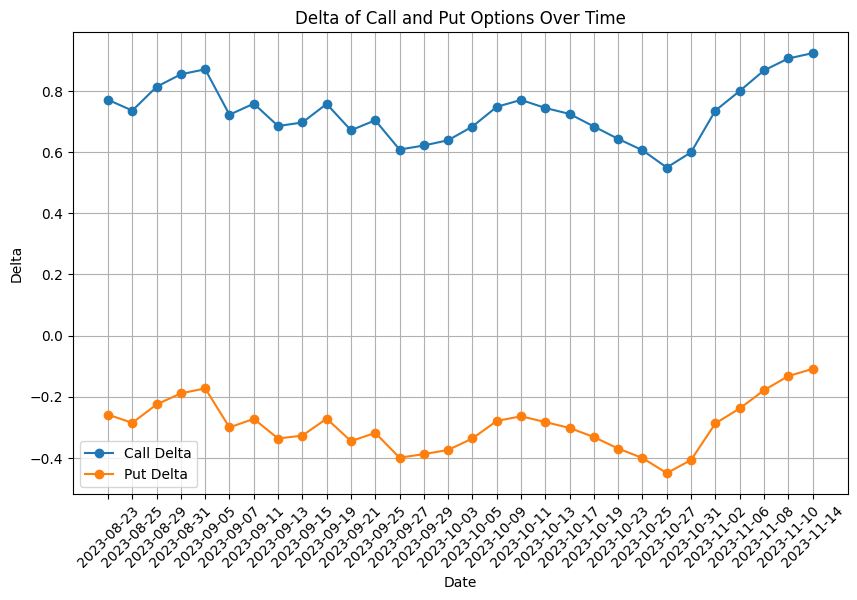

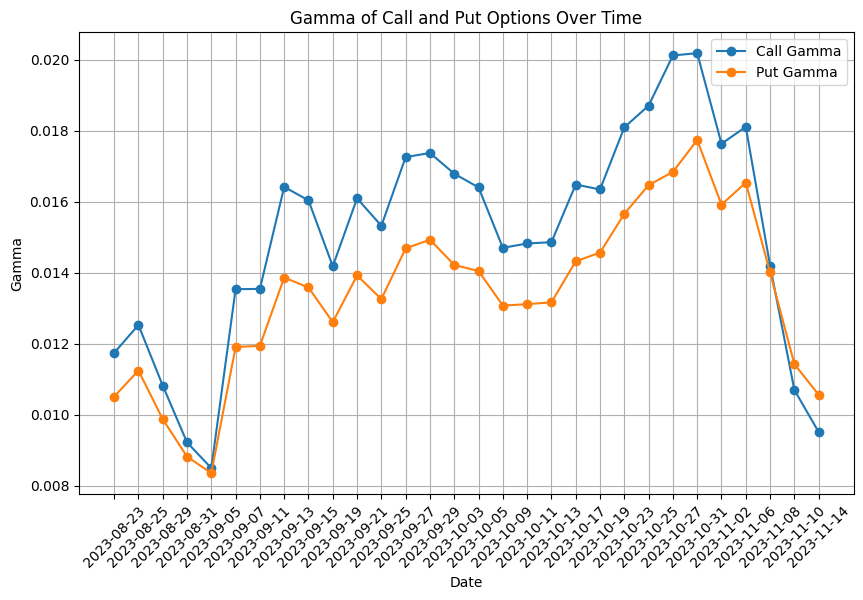

In [29]:
freq = 2
total_mean_squared_error, total_error, portfolio_values, greek_and_volatility_data = delta_gamma_hedge(df_result, freq, "C170", "P170")
print(greek_and_volatility_data)
plot_deltas(greek_and_volatility_data)
plot_gammas(greek_and_volatility_data)

# Delta-Vega hedging a single option

In [ ]:
# TODO: refactor when time
def delta_vega_hedge(option_data, freq, call_column, put_column, costs = 0):
    # Initial values at time t = 0
    initial = option_data.iloc[0]
    option_amount = 1000
    interest_rate = initial['Interest rate']
    stock_price = initial['Underlying']
    call_option_price = initial[call_column]
    put_option_price = initial[put_column]
    call_strike = int(call_column[1:])
    put_strike = int(put_column[1:])
    time_to_maturity = initial['T']
    total_mean_squared_error = []
    
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=call_strike, t=time_to_maturity, r=interest_rate, flag='c')
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=put_strike, t=time_to_maturity, r=interest_rate, flag='p')

    # Initial stuff at t = 0
    # REMEMBER: Delta of the underlying stock is 1 and Vega is 0 (Gamma is 0)
    # To make the portfolio Vega (and Gamma) neutral, we have to take both call and put options
    call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(initial, call_volatility, put_volatility, call_strike, put_strike)

    # Construct portfolio OP, long position ?
    OP = option_amount * call_option_price + option_amount * put_option_price

    # Construct portfolio RE, short position ?
    RE = - call_delta * stock_price * option_amount + put_delta * stock_price * option_amount
    portfolio_values = [OP + RE]
    transaction_costs = 0
    
    print("================ Initial values: =================")
    print("Date:", initial['Date'])
    print(f"Value of single call option (for {option_amount} stocks) according to BSM: ", round(OP, 2))
    print("Value of the short position according to BSM: ", round(RE, 2))
    print("================ GREEKS =================")
    print("Delta of the Call option according to BSM: ", round(call_delta, 4))
    print("Delta of the Put option according to BSM: ", round(put_delta, 4))
    print("Vega of the Call option according to BSM: ", round(call_vega, 4))
    print("Vega of the Put option according to BSM: ", round(put_vega, 4))
    print('==================================================')
    print('\n')
    
    # Constructing a dataframe for option greeks and implied volatilities, which can then be used later for analysis purposes
    column_names = ['call_delta', 'put_delta', 'call_vega', 'put_vega','call_volatility', 'put_volatility', 'rehedging']
    idx = option_data['Date']

    new_row = pd.DataFrame({'call_delta': call_delta, 'put_delta': put_delta, 'call_vega': call_vega, 'put_vega': put_vega,
                        'call_volatility': call_volatility, 'put_volatility': put_volatility, 'rehedging': False}, index=idx)

    greek_and_volatility_data = pd.DataFrame(data = new_row, index = idx, columns=column_names)
    new_rows = []

    hedge = False
    
    # Loop through dates in the dataframe
    # We will also calculate changes in the portfolio's OP and RE, d OP and d RE, and count the mean squared error A_0 = d OP - d RE
    for i in range(1, len(option_data)-1):
        new_OP = option_data[call_column][i] * option_amount + option_data[put_column][i] * option_amount
        new_RE = -call_delta * option_data['Underlying'][i] * option_amount + put_delta * option_data['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE
        a_0 = d_OP + d_RE # In a ideal situation this should be 0 = IMMUNE TO CHANGES
        total_mean_squared_error.append(a_0**2)
        portfolio_values.append(OP + RE + transaction_costs)

        print('=================================================')
        print("Date:", option_data['Date'][i])
        print(f"Value of Call options (for {option_amount} stocks) according to BSM: ", round(new_OP, 2))
        print("Value of the new short position according to BSM: ", round(new_RE, 2))
        print("Difference of the long positions: ", round(d_OP))
        print("Difference of the short positions: ", round(d_RE))
        print('================ GREEKS =========================')
        print("Delta of the Call option according to BSM: ", round(call_delta, 4))
        print("Delta of the Put option according to BSM: ", round(put_delta, 4))
        print("Vega of the Call option according to BSM: ", round(call_vega, 4))
        print("Vega of the Put option according to BSM: ", round(put_vega, 4))
        print("Total error, difference of the portfolios: ", round(a_0, 2))
        print('=================================================')
        print('\n')

        OP = new_OP
        RE = new_RE
        
        # Rehedge interval
        # Compute new Deltas, Vegas, and Gammas every time we want to rehedge
        # We need to rehedge, because as time goes by, the price of the underlying changes
        # This affects the option Greeks that measure the market
        if i % freq == 0:
            print("Rehedging date: ", option_data['Date'][i])
            
            call_volatility = implied_volatility(price=option_data[call_column][i], S=option_data['Underlying'][i], K=call_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='c')
            put_volatility = implied_volatility(price=option_data[put_column][i], S=option_data['Underlying'][i], K=put_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='p')
            call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(option_data.iloc[i], call_volatility, put_volatility, call_strike, put_strike)
            
            print("====== DELTA VEGA NEUTRAL ======")

            delta_vega_coefficients = np.array([
                [call_delta, call_vega,],
                [put_delta, put_vega]
            ])

            right_hand_side = np.array([
                option_amount * (call_delta + put_delta), option_amount * (call_vega + put_vega)
            ])
            
            delta_vega_neutral = np.linalg.solve(delta_vega_coefficients, right_hand_side)
            print('To make the portfolio delta vega neutral, you need to adjust the amount of call options: ', delta_vega_neutral[0])
            print('To make the portfolio delta vega neutral, you need to adjust the amount of put options: ', delta_vega_neutral[1])
            print("\n")

            hedge = True

        new_row = {'call_delta': call_delta, 'put_delta': put_delta, 'call_vega': call_vega, 'put_vega': put_vega,
                   'call_volatility': call_volatility, 'put_volatility': put_volatility, 'rehedging': hedge, 'Date': option_data['Date'][i]}
        
        new_rows.append(new_row)

    # First and last day is missing for some reason
    # However, possibly not needed because the rehedging does not happen on the first and last day anyway
    greek_and_volatility_data = pd.DataFrame(new_rows)
    greek_and_volatility_data.set_index('Date', inplace=True)

    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1] # Sum 1 to n-1 of the MSEs
    total_error *= (1 / (len(total_mean_squared_error)-1) )
    print('========== Total Mean Squared Error ==============')
    print("The total mean squared error is : ", total_error)
    print('==================================================')

    return total_mean_squared_error, total_error, portfolio_values, greek_and_volatility_data # return daily errors and the total error for plotting purposes


In [ ]:
freq = 2
total_mean_squared_error, total_error, portfolio_values, greek_and_volatility_data = delta_vega_hedge(df_result, freq, "C170", "P170")
print(total_mean_squared_error)
print(total_error)
print(portfolio_values)

In [ ]:
hedging_frequencies = [1, 10, 30]
plt.figure(figsize=(10, 6))
for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, greek_and_volatility_data = delta_vega_gamma_hedge(df_result, freq, "C170", "P170")
    plt.plot(total_mean_squared_error, label=f'Hedging Frequency: {freq} days')
    
plt.xlabel('Days')
plt.ylabel('Daily Error')
plt.title('Daily Error vs Hedging Frequency')
plt.legend()
plt.show()

In [ ]:
hedging_frequencies = [1, 2, 5, 10, 30]

results_dict = {'Frequency': [], 'Total_MSE': []}

for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, greek_and_volatility_data = delta_vega_gamma_hedge(df_result, freq, "C170", "P170")
    results_dict['Frequency'].append(freq)
    results_dict['Total_MSE'].append(total_error)

# Plotting
plt.plot(results_dict['Frequency'], results_dict['Total_MSE'], marker='o')
plt.xlabel('Hedging Frequency (days)')
plt.ylabel('Total Mean Squared Error')
plt.title('Total Mean Squared Error vs Hedging Frequency')
plt.show()

In [ ]:
# NOTE: not ready. The costs dont work as percents yet; they are simply 100 000 * cost
# for illustrative purposes. This corresponds to fixed costs, e.g. 100€ per trade.
# These costs mean fixed costs of 0€, 2000€ and 5000€ per trade.

costs = [0.00, 0.02, 0.05]
plt.figure(figsize=(10, 6))
for c in costs:
    total_mean_squared_error, total_error, portfolio_values, greek_and_volatility_data = delta_vega_gamma_hedge(df_result, freq, "C170", "P170", costs=c) #every other day
    plt.plot(portfolio_values, label=f'Transaction costs: ${c*100}k') # change to % once done

plt.xlabel('Days')
plt.ylabel('Portfolio value')
plt.title('Portfolio value with transactions costs, hedging every other day')
plt.legend()
plt.show()